In [18]:
import sys
!{sys.executable} -m pip install pandas requests matplotlib numpy


You should consider upgrading via the 'C:\Users\vikstilm\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import requests

def fetch_and_save_tournaments(file_name):
    tournament_types = {'scheduled': 1, 'results': 3}
    tournaments = []
    for tournament_type in tournament_types:
        response = requests.get(url=f'https://api.ussquash.com/resources/tournaments?TopRecords=500&ngbId=10142&OrganizerType=1&Sanctioned=1&Status={tournament_types[tournament_type]}')
        js = json.loads(response.content)
        for tournament in js:
            tournament['Type'] = tournament_type
            tournaments.append(tournament)
            print(f'Tournament type: {tournament_type}')
            print(f"Name: {tournament['TournamentName']}, {tournament['StartDate']} - {tournament['EndDate']}")
        print('\n')
    tournaments_df = pd.DataFrame(tournaments, columns=tournaments[0].keys())
    tournaments_df.to_pickle(f'data/{file_name}')


def load_pickle(file_name):
    pickle = pd.read_pickle(f'data/{file_name}')
    return pickle


def fetch_and_save_matches(tournaments_df, file_name):
    # Only take matches from tournaments that have passed.
    #results_df = tournaments_df.loc[tournaments_df['Type'] == 'results']
    results_df = tournaments_df
    tournament_ids = results_df['TournamentID'].values.tolist()
    tournament_start_dates = results_df['StartDate'].values.tolist()
    dates_ids = list(zip(tournament_ids, tournament_start_dates))
    matches_js = []
    for tournament in dates_ids:
        response = requests.get(url = f'https://api.ussquash.com/resources/res/trn/live_matrix?date={tournament[1]}&tournamentId={tournament[0]}')
        js = json.loads(response.content)
        for entry in js:
            if len(entry) > 1:
                entry['TournamentID'] = tournament[0]
                matches_js.append(entry)
        print(f'Fetched matches from tournament {tournament[1]}. Total matches loaded: {len(matches_js)}')
    matches_df = pd.DataFrame(matches_js, columns=matches_js[0].keys())
    matches_df.to_pickle(f'data/{file_name}')


def get_player_matches(matches_df, player_name):
    player_matches = matches_df.loc[(matches_df['hPlayerName'] == player_name) | (matches_df['vPlayerName'] == player_name)]
    return player_matches

In [ ]:
if not path.exists('data/tournaments.pkl'):
    fetch_and_save_tournaments(file_name='tournaments.pkl')
tournaments_df = load_pickle(file_name='tournaments.pkl')
if not path.exists('data/matches.pkl'):
    fetch_and_save_matches(tournaments_df, file_name='matches.pkl')
matches_df = load_pickle(file_name='matches.pkl')
pass

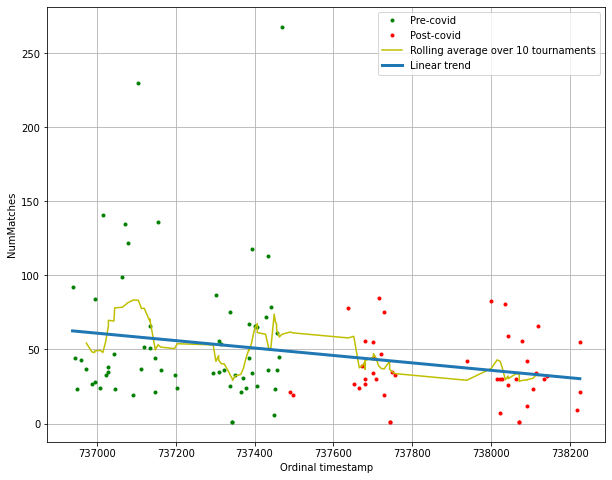

In [144]:
import datetime as dt
pd.set_option('mode.chained_assignment',None)

tournaments_filtered = tournaments_df[tournaments_df['NumMatches'] > 0]

# Mark covid
start_dates = pd.to_datetime(tournaments_filtered['StartDate'].values.tolist())
len(start_dates)
covid = []
for start_date in start_dates:
    if start_date < pd.to_datetime('2020-03-01'):
        covid.append(0)
    else:
        covid.append(1)
tournaments_filtered['covid'] = covid


tournaments_filtered['StartDateTimeStamp'] = pd.to_datetime(tournaments_filtered['StartDate'])
tournaments_filtered['StartDateTimeStamp'] = tournaments_filtered['StartDateTimeStamp'].map(dt.datetime.toordinal)

plt.figure(figsize=(10,8))
plt.xlabel('Ordinal timestamp')
plt.ylabel('NumMatches')
plt.grid()
tournaments_filtered_nocovid = tournaments_filtered.loc[tournaments_filtered['covid'] == 0]
tournaments_filtered_yescovid = tournaments_filtered.loc[tournaments_filtered['covid'] == 1]
plt.plot(tournaments_filtered_nocovid['StartDateTimeStamp'], tournaments_filtered_nocovid['NumMatches'], 'g.', label='Pre-covid')
plt.plot(tournaments_filtered_yescovid['StartDateTimeStamp'], tournaments_filtered_yescovid['NumMatches'], 'r.', label='Post-covid')

window = 10
rolling_average = tournaments_filtered['NumMatches'].rolling(10, center=True).mean()
plt.plot(tournaments_filtered['StartDateTimeStamp'], rolling_average, 'y', label=f'Rolling average over {window} tournaments')

m, b = np.polyfit(tournaments_filtered['StartDateTimeStamp'], tournaments_filtered['NumMatches'], 1)
plt.plot(tournaments_filtered['StartDateTimeStamp'], m * tournaments_filtered['StartDateTimeStamp'] + b, linewidth=3, label='Linear trend')
plt.legend()